<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

**Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.**

Порядок выполнения работы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

**Импортируем необходимые библиотеки.**

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor

**Записываем в переменную датасет.**

In [4]:
url = ('https://github.com/MEfse/project/blob/main/Project/%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5%20%D1%80%D1%8F%D0%B4%D1%8B/taxi.csv?raw=true')

In [5]:
data = pd.read_csv(url)

**Отобразим общую информацию.**

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


**Переведем столбец** `datetime` во временой тип данных.

In [7]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

In [8]:
print('Минимальное значение времени:', data['datetime'].min())
print('Максимальное значение времени:', data['datetime'].max())

Минимальное значение времени: 2018-03-01 00:00:00
Максимальное значение времени: 2018-08-31 23:50:00


**Данные** представлены **за полгода.**

In [9]:
display(data['datetime'].head(5))

0   2018-03-01 00:00:00
1   2018-03-01 00:10:00
2   2018-03-01 00:20:00
3   2018-03-01 00:30:00
4   2018-03-01 00:40:00
Name: datetime, dtype: datetime64[ns]

**Разница** между строками составляет **10 мин.**

In [10]:
print('Минимальное значение заказов:', data['num_orders'].min())
print('Максимальное значение заказов:', data['num_orders'].max())

Минимальное значение заказов: 0
Максимальное значение заказов: 119


Количество заказов **сильно отличается.** Но т.к. разница по времени небольшая, то сейчас сложно сказать, что нулевое значение является аномалией. **Если количество заказов** такси **за** условные **30 мин или 1 час тоже равно нулю, то это 100% аномалия.**

In [11]:
display(data['num_orders'].head(5))

0     9
1    14
2    28
3    20
4    32
Name: num_orders, dtype: int64

Сделаем **индекс временным.**

In [12]:
data = data.set_index('datetime')

In [13]:
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


**Данные** исследованы и **готовы к анализу.**

## Анализ

Построем график.

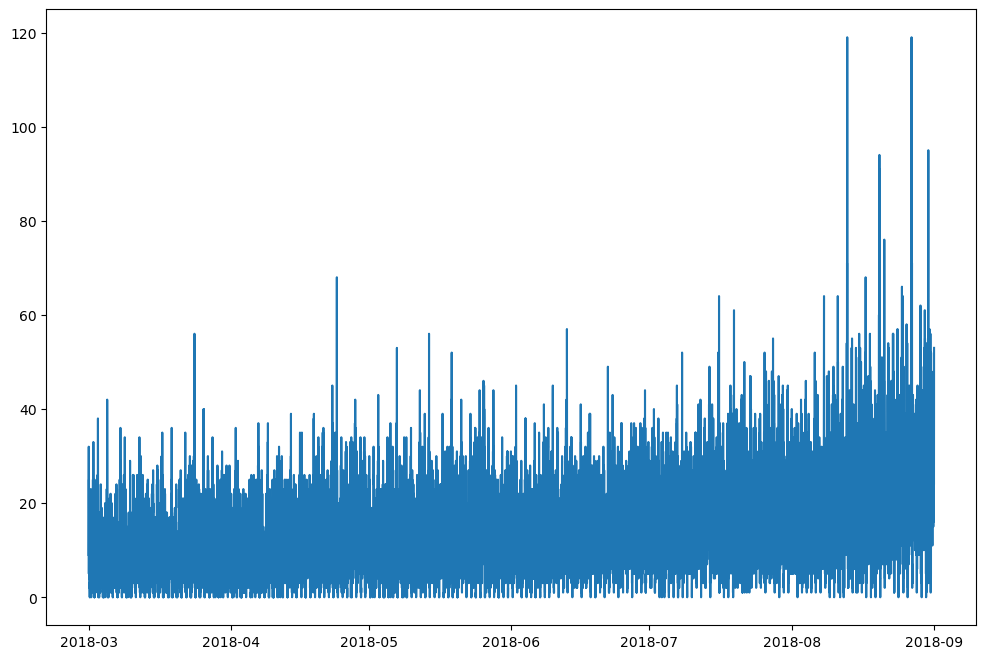

In [14]:
plt.figure(figsize=(12, 8));
plt.plot(data);

**Данные в таком виде не подлежат анализу**, т.к. очень маленькое время чтобы отследить изменения, поэтому выполним `ресемпинг`.

In [15]:
data = data.resample('1H').sum()

Добавим **скользящее среднее.**

In [16]:
data['rolling_mean'] = data.rolling(10).mean()

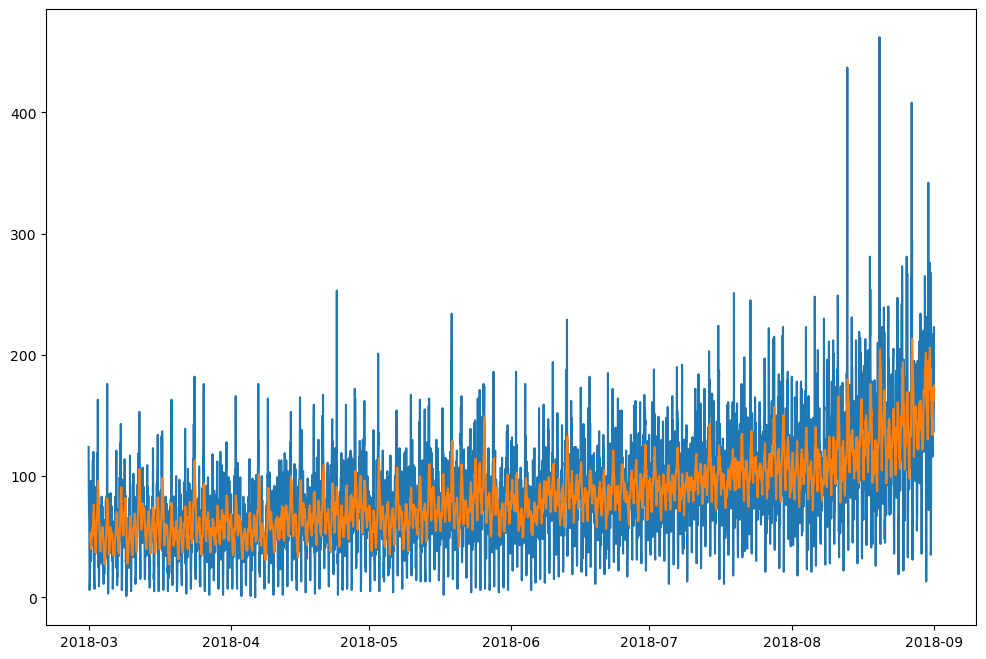

In [17]:
plt.figure(figsize=(12, 8));
plt.plot(data);

На данном графике можно заметить, что **количество заказов в среднем повышается.**

Рассмотрим `тренды` и `сезонность`.


* `Тренд`  — плавное изменение среднего значения ряда без повторяющихся закономерностей. 
* `Сезонность`  — циклично повторяющиеся закономерности во временном ряду. 

In [18]:
data = data.drop(['rolling_mean'], axis=1)

In [19]:
decomposed = seasonal_decompose(data)

**Построем график** по тренду, сезонности и остаткам.

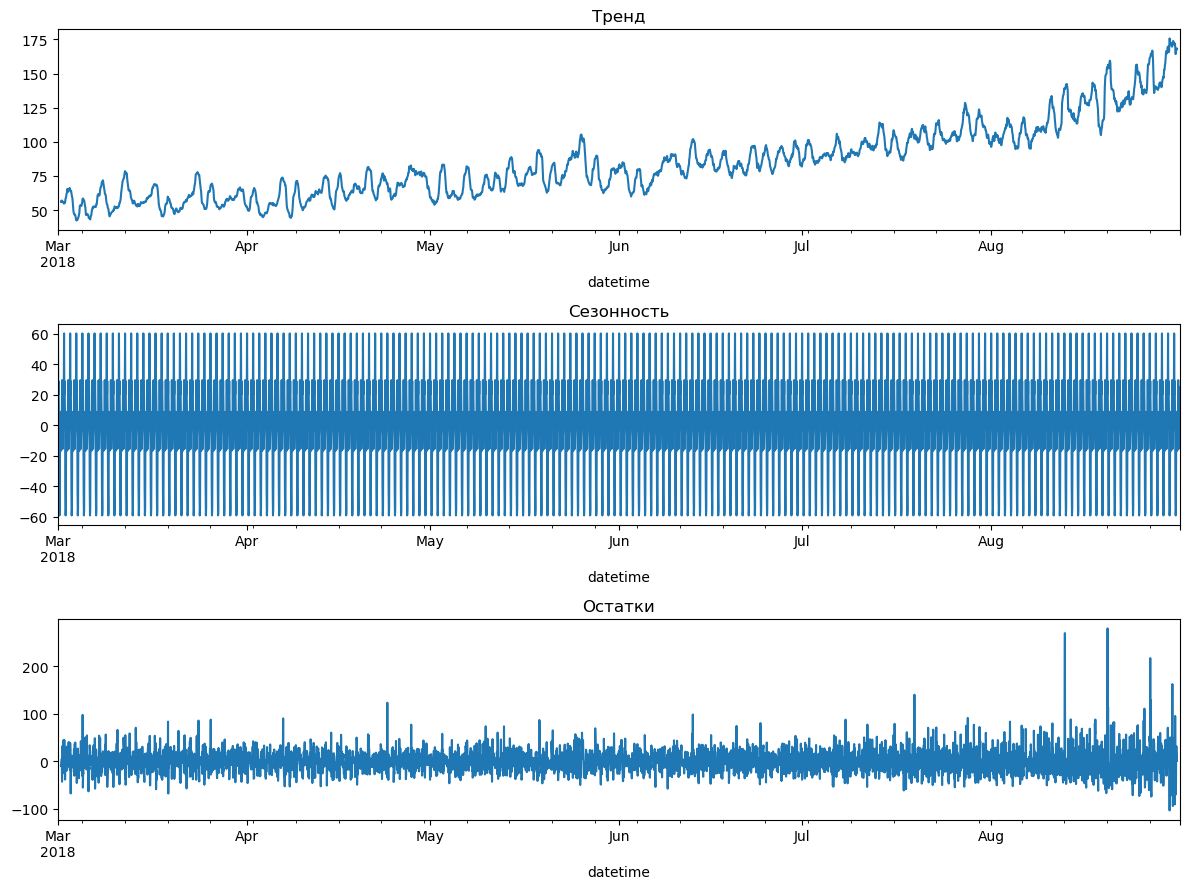

In [20]:
plt.figure(figsize=(12, 9));
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остатки')
plt.tight_layout()

Рассмотрим детальнее - **период две недели.** 

In [21]:
data_week = data['2018-03-01 00:00:00' : '2018-03-02 23:50:00']

In [22]:
decomposed_week = seasonal_decompose(data_week)

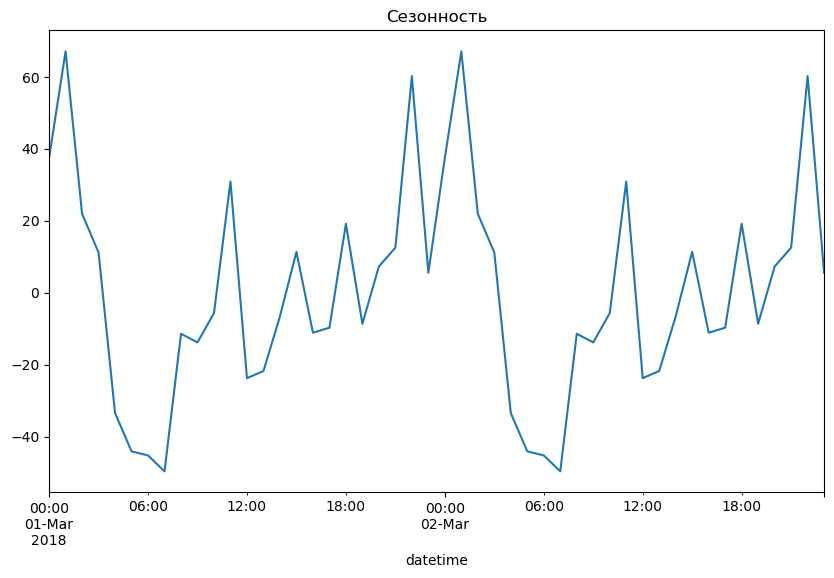

In [23]:
plt.figure(figsize=(10, 6));
decomposed_week.seasonal.plot();
plt.title('Сезонность');

* На ночь приходится пик. 
* На утро приходится спад.
* На день и вечер приходится примерно среднее значение за сутки.

## Обучение

Подготовим функцию для обучения моделей.

In [24]:
data_model = data.copy()

In [25]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
      
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [26]:
make_features(data_model, 3, 2)

Сделаем разбивку данных. 

In [27]:
train_valid, test = train_test_split(data_model, shuffle=False, test_size=.1)

In [28]:
train, valid = train_test_split(train_valid, test_size=.25)

In [29]:
train = train.dropna()
valid = valid.dropna()
test = test.dropna()

In [30]:
print(f'Размер тренировочной выборки: {train.shape} процент от общего {round(train.shape[0] / data.shape[0] * 100,2)}%')
print(f'Размер валидационной выборки: {valid.shape} процент от общего {round(valid.shape[0] / data.shape[0] * 100,2)}%')
print(f'Размер тестовой выборки: {test.shape} процент от общего {round(test.shape[0] / data.shape[0] * 100,2)}%')

Размер тренировочной выборки: (2977, 9) процент от общего 67.41%
Размер валидационной выборки: (994, 9) процент от общего 22.51%
Размер тестовой выборки: (442, 9) процент от общего 10.01%


In [31]:
display(data_model.head(5))

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,104.5
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,78.0
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,68.5


In [32]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']

X_valid = valid.drop(['num_orders'], axis=1)
y_valid = valid['num_orders']

X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

In [33]:
best_model_tree, best_model_forest = None, None

best_result_tree, best_result_forest = 1000, 1000

In [34]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
predict_linear = model_linear.predict(X_valid)
rmse_linear = round(mean_absolute_error(y_valid, predict_linear), 3)
print(f"RMSE линейной регрессии {rmse_linear}")

RMSE линейной регрессии 24.211


In [35]:
for depth in range(1, 20, 1):
    
    model_tree = DecisionTreeRegressor(max_depth=depth)
    model_tree.fit(X_train, y_train)
    predict_tree = model_tree.predict(X_valid)
    rmse_tree = round(mean_absolute_error(y_valid, predict_tree),3)
    
    if best_result_tree > rmse_tree:
        best_result_tree = rmse_tree
        best_model_tree = model_tree
        
            
print(f"RMSE дерева решений {best_result_tree}, лучшая модель {best_model_tree}")

RMSE дерева решений 24.164, лучшая модель DecisionTreeRegressor(max_depth=6)


In [36]:
for depth in range(1, 10, 1):
    for est in range(1, 10, 1):
        
        model_forest = RandomForestRegressor(max_depth=depth, n_estimators=est)
        model_forest.fit(X_train, y_train)
        predict_forest = model_forest.predict(X_valid)
        rmse_forest = round(mean_absolute_error(y_valid, predict_forest), 3)
        
        if best_result_forest > rmse_forest:
            best_result_forest = rmse_forest
            best_model_forest = model_forest
        
print(f"RMSE случайного леса {best_result_forest}, лучшая модель {best_model_forest}")

RMSE случайного леса 23.36, лучшая модель RandomForestRegressor(max_depth=7, n_estimators=5)


In [37]:
model_dummy = DummyRegressor()
model_dummy.fit(X_train, y_train)
predict_dummy = model_forest.predict(X_valid)
rmse_dummy = round(mean_absolute_error(y_valid, predict_dummy), 3)
print(f"RMSE дамми регрессора {rmse_dummy}")

RMSE дамми регрессора 23.757


In [38]:
cat = CatBoostRegressor(iterations = 15000)
cat.fit(X_train, y_train, verbose = 2000, plot=True)
predict_cat = cat.predict(X_valid)
rmse_cat = round(mean_absolute_error(y_valid, predict_cat), 3)
print()
print(f"RMSE кэтбуста {rmse_cat}")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.005381
0:	learn: 38.7304807	total: 70.5ms	remaining: 17m 37s
2000:	learn: 26.7160358	total: 2.46s	remaining: 16s
4000:	learn: 24.1582648	total: 4.95s	remaining: 13.6s
6000:	learn: 22.1850679	total: 7.73s	remaining: 11.6s
8000:	learn: 20.7633419	total: 10.4s	remaining: 9.08s
10000:	learn: 19.5445433	total: 13.1s	remaining: 6.56s
12000:	learn: 18.4703838	total: 15.8s	remaining: 3.94s
14000:	learn: 17.4800920	total: 18.6s	remaining: 1.33s
14999:	learn: 17.0374871	total: 20.1s	remaining: 0us

RMSE кэтбуста 23.434


In [39]:
model_rmse = pd.DataFrame({'RMSE': [rmse_linear, 
                                    rmse_tree, 
                                    rmse_forest, 
                                    rmse_cat, 
                                    rmse_dummy]}, 
                          index = ['Линейная регрессия', 
                                   'Дерево решений',
                                   'Случайный лес',
                                   'Кэтбуст',
                                   'Дамми регрессор']).sort_values('RMSE', ascending=True)

In [40]:
display(model_rmse)

,RMSE
Кэтбуст,23.434
Случайный лес,23.757
Дамми регрессор,23.757
Линейная регрессия,24.211
Дерево решений,32.962


Лушчая модель - Кэтбуст.

## Тестирование

Потестируем модель.

In [41]:
predict_cat_t = cat.predict(X_test)
rmse_cat_t = round(mean_absolute_error(y_test, predict_cat_t), 3)
print()
print(f"RMSE кэтбуста {rmse_cat_t}")


RMSE кэтбуста 41.133


## Вывод

Выполнена подготовка данных, произведен анализ, обучены различные модели (с подбором гиперпараметров), лучшая модель (кэтбуст) протестирована. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48